<a href="https://colab.research.google.com/github/oksusudom/ML-Creadit-Card-Lead-Prediction/blob/main/improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. 필요한 패키지 불러오기


In [2]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# visualization options

rcParams["figure.figsize"] = (10,6)
rcParams['font.family'] = 'monospace'
rcParams['font.style'] = 'normal'
rcParams['axes.grid'] = True
rcParams['axes.axisbelow'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 0.2

sns.set_context('poster', font_scale=0.5)

# 1. 데이터 불러오기

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/URCLASS/Section2_Project/credit card/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/URCLASS/Section2_Project/credit card/test.csv')

In [4]:
train_df

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [5]:
test_df

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No
...,...,...,...,...,...,...,...,...,...,...
105307,DBENJOYI,Male,52,RG268,Salaried,X2,86,Yes,4242558,Yes
105308,CWQ72DWS,Male,55,RG277,Other,X2,86,Yes,1159153,No
105309,HDESC8GU,Male,35,RG254,Salaried,X4,15,No,1703727,No
105310,2PW4SFCA,Male,53,RG254,Other,X3,93,No,737178,Yes


#. 2. 변수 분포 확인, 시각화

In [6]:
# Is_Lead => 0 = No, 1 = Yes
target = 'Is_Lead'

In [7]:
# 타겟 데이터 범주의 비율 확인
y_train = train_df[target]
y_train.value_counts(normalize=True)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

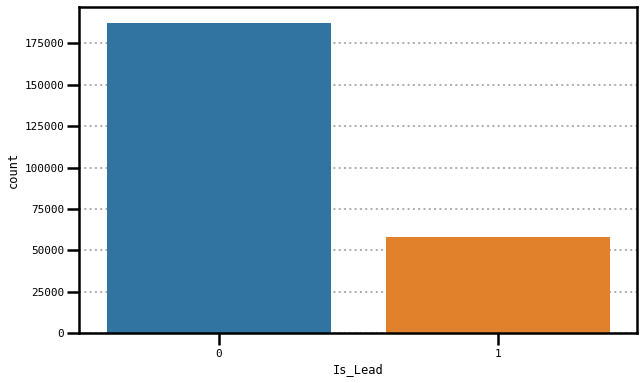

In [8]:
# Target 데이터 분포 확인

sns.countplot(x = y_train);

# imbalanced 확인

In [9]:
# train_df의 Credit_Product에서 결측치 확인 -> 뒤에서 처리
train_df.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [10]:
# test_df에도 Credit_Product에 결측치가 있음.
test_df.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In [11]:
# 불필요한 ID column 삭제
train_df = train_df.drop(['ID'],axis=1)
test_df = test_df.drop(['ID'], axis=1)

train_df

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
245720,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [12]:
# dtype 확인
train_df.dtypes

Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [13]:
train_df.describe(include='all')

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,245725,245725.000000,245725,245725,245725,245725.000000,216400,2.457250e+05,245725,245725.000000
unique,2,NaN,35,4,4,NaN,2,NaN,2,NaN
top,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No,NaN
freq,134197,NaN,35934,100886,103718,NaN,144357,NaN,150290,NaN
mean,NaN,43.856307,NaN,NaN,NaN,46.959141,NaN,1.128403e+06,NaN,0.237208
std,NaN,14.828672,NaN,NaN,NaN,32.353136,NaN,8.529364e+05,NaN,0.425372
min,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,2.079000e+04,NaN,0.000000
25%,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.043100e+05,NaN,0.000000
50%,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.946010e+05,NaN,0.000000
75%,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.366666e+06,NaN,0.000000


Region_Code의 cardinality가 35로 높은 편이다.

## Numerical Features 분포 확인

Age, Vintage, Avg_Account_Balance

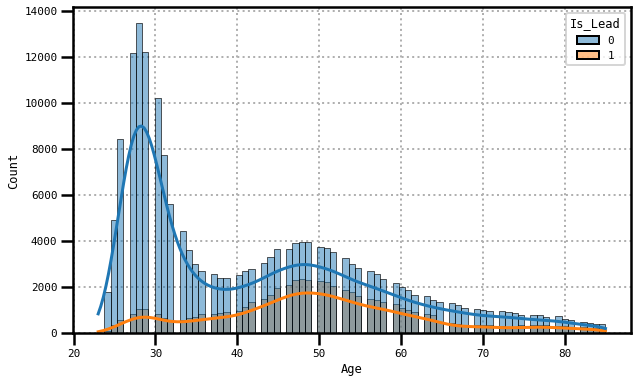

In [14]:
# Target 특성에 따른 Age 분포
sns.histplot(data = train_df, x = train_df['Age'], hue = "Is_Lead", kde = True);

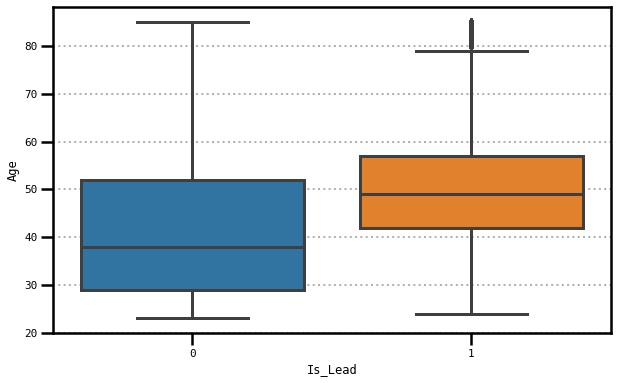

In [15]:
sns.boxplot(x="Is_Lead",  y="Age", data=train_df)

plt.xlabel('Is_Lead')
plt.ylabel('Age');

- 전체 이용고객 중 20 중반에서 30 중반의 고객이 다수를 차지했다.
- 그 다음으로는 40대 중반에서 50대 중반 고객의 수가 많다.
- 40대 중반 ~ 50대 중반 고객은 다른 나이대에 비해 제안에 관심있는 비율이 높다.

-> 4050 연령층의 과반수 이상이 제안에 관심있음.

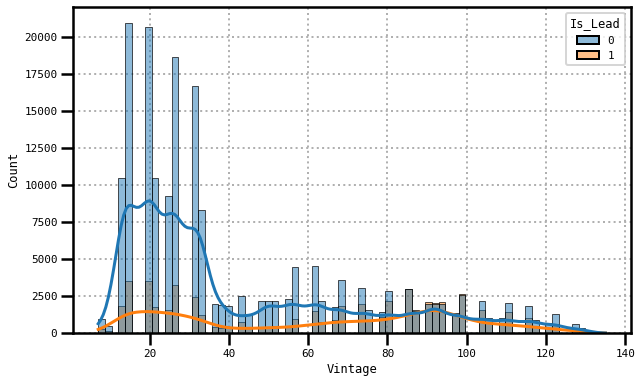

In [16]:
# Target 특성에 따른 Vintage 분포
sns.histplot(data = train_df, x = train_df['Vintage'], hue = "Is_Lead", kde = True);

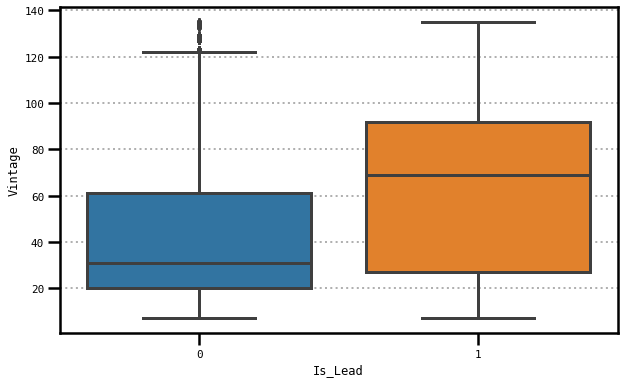

In [17]:
sns.boxplot(x="Is_Lead",  y="Vintage", data=train_df)

plt.xlabel('Is_Lead')
plt.ylabel('Vintage');

- Vintage가 80~100인 고객은 제안에 대부분 관심을 갖고 있다.
- Vintage가 40~60 차 고객의 제안 관심도는 가장 낮았다.

- Vintage가 비교적 높은 고객들이 관심있어하는 제안이다.
 -> Vintage가 40~60인 고객들의 관심도가 낮은 이유를 확인할 필요가 있다.

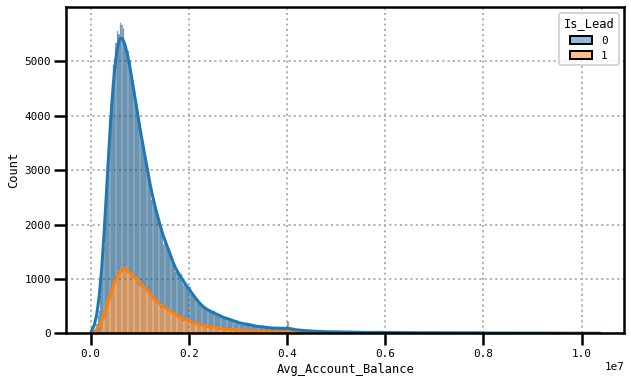

In [18]:
# Target 특성에 따른 Avg_Account_Balance 분포
sns.histplot(data = train_df, x = train_df['Avg_Account_Balance'], kde = True, hue = 'Is_Lead', multiple = 'stack');

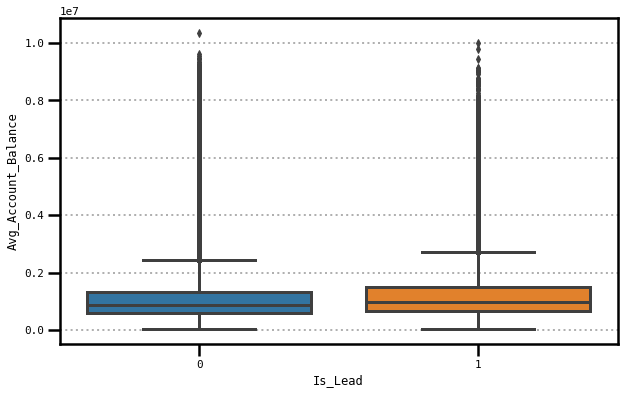

In [19]:
sns.boxplot(x="Is_Lead",  y="Avg_Account_Balance", data=train_df)

plt.xlabel('Is_Lead')
plt.ylabel('Avg_Account_Balance');

- Avg_Account_Balance는 제안에 관심이 있는 고객과 없는 고객이 비슷한 분포를 보였다.

In [20]:
print(np.mean(train_df[train_df['Is_Lead'] == 1]['Avg_Account_Balance']))
print(np.mean(train_df[train_df['Is_Lead'] == 0]['Avg_Account_Balance']))

1210034.0418954159
1103018.015461195


# 상관관계 확인

Numerical features 간 상관관계

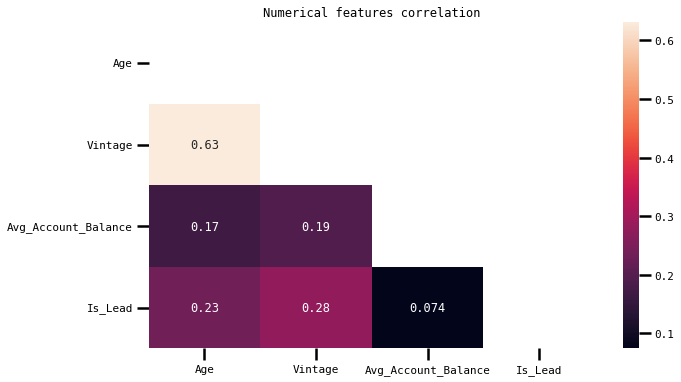

In [52]:
# Numerical features 간 상관관계 heatmap

corr = train_df.corr()

mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
plt.title('Numerical features correlation')
sns.heatmap(corr,mask=mask, annot=True);

##Categorical Features 분포 확인

Gender, Region Code, Occupation, Channel Code, Credit Product, Is_Active

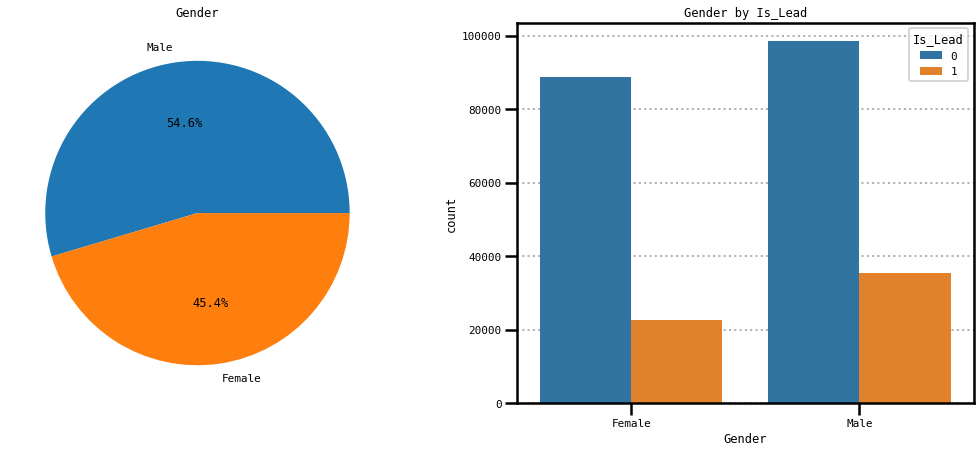

In [21]:
# Gender

fig, ax = plt.subplots(1, 2, figsize=(18,7)) 
# subplot : 한 화면에서 여러 그래프를 나눠서 출력하는 기능 / plt.subplots((행 ,열, 그래프의 크기(가로, 세로)))
train_df['Gender'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0])
# pd.Series.value_counts() : 유일한 값 별로 개수 세기 / .pie (explode = 두 조각간의 거리, autopct = 각 범주가 데이터에서 차지하는 비율, shadow = 그림자, startangle = pie의 시작각도)
ax[0].set_title('Gender') # 파이 그래프 이름
ax[0].set_ylabel('') # 파이 그래프
 
sns.countplot('Gender', data=train_df, hue = 'Is_Lead', ax=ax[1])# countplot : 각 카테고리 값별로 데이터가 얼마나 있는지 표시 / countplot(x='column_name', data=dataframe)
ax[1].set_title('Gender by Is_Lead')
plt.show() # 막대 그래프

In [22]:
# Male의 Is_Lead가 1인 비율 26.51%
train_df[train_df['Gender'] == 'Male']['Is_Lead'].value_counts(normalize=True) * 100

0    73.484504
1    26.515496
Name: Is_Lead, dtype: float64

In [23]:
# Female의 Is_Lead가 1인 비율 20.35%
train_df[train_df['Gender'] == 'Female']['Is_Lead'].value_counts(normalize=True) * 100

0    79.641884
1    20.358116
Name: Is_Lead, dtype: float64

- 남성의 제안 관심 비율 26.51%

- 여성의 제안 관심 비율 20.35%

성별에 따른 제안 관심은 큰 차이가 없다.

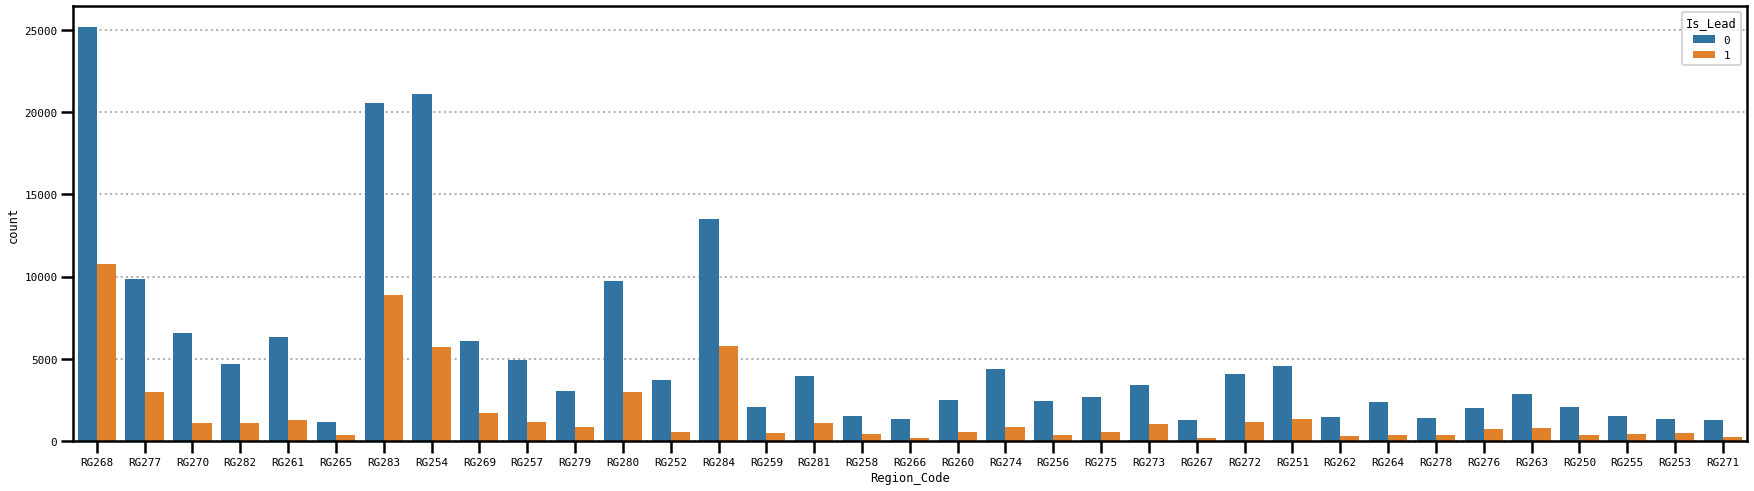

In [24]:
# Region_Code

plt.figure(figsize = (30,8))
sns.countplot('Region_Code', data=train_df, hue = 'Is_Lead')# countplot : 각 카테고리 값별로 데이터가 얼마나 있는지 표시 / countplot(x='column_name', data=dataframe)
ax[0].set_title('Region_Code by Is_Lead')
plt.show() # 막대 그래프

In [25]:
train_df[train_df['Region_Code'] == 'RG268']['Is_Lead'].value_counts(normalize=True) * 100

0    70.020037
1    29.979963
Name: Is_Lead, dtype: float64

In [26]:
train_df[train_df['Region_Code'] == 'RG283']['Is_Lead'].value_counts(normalize=True) * 100

0    69.795349
1    30.204651
Name: Is_Lead, dtype: float64

In [27]:
train_df[train_df['Region_Code'] == 'RG284']['Is_Lead'].value_counts(normalize=True) * 100

0    69.89648
1    30.10352
Name: Is_Lead, dtype: float64

In [28]:
train_df.groupby(['Region_Code', 'Is_Lead']).size().unstack(fill_value=0)

Is_Lead,0,1
Region_Code,,
RG250,2103,393
RG251,4569,1381
RG252,3694,592
RG253,1377,481
RG254,21127,5713
RG255,1549,469
RG256,2446,401
RG257,4931,1170
RG258,1521,430


In [29]:
region_groups = train_df.groupby('Region_Code')

region_groups.mean()['Is_Lead'].sort_values(ascending=False)

Region_Code
RG283    0.302047
RG284    0.301035
RG268    0.299800
RG276    0.277858
RG253    0.258881
RG265    0.258732
RG273    0.237714
RG280    0.235538
RG255    0.232408
RG251    0.232101
RG277    0.231951
RG279    0.225604
RG263    0.221861
RG269    0.221671
RG258    0.220400
RG272    0.219916
RG278    0.219539
RG281    0.218732
RG254    0.212854
RG259    0.193735
RG282    0.192143
RG257    0.191772
RG260    0.190997
RG262    0.180649
RG271    0.169261
RG261    0.167955
RG275    0.167334
RG274    0.164964
RG250    0.157452
RG267    0.148965
RG270    0.144301
RG256    0.140850
RG266    0.139417
RG252    0.138124
RG264    0.137129
Name: Is_Lead, dtype: float64

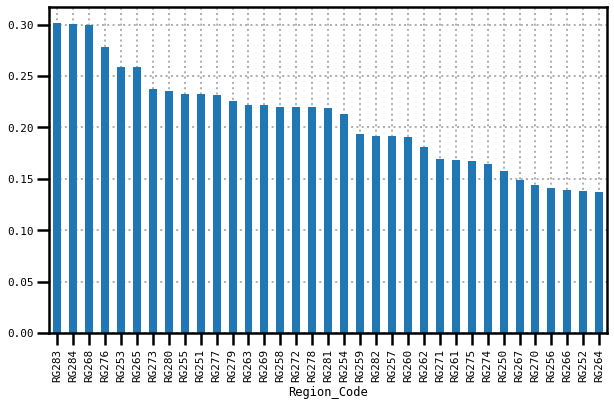

In [30]:
region_groups.mean()['Is_Lead'].sort_values(ascending=False).plot.bar();

- Region Code 중 Is_Lead가 '1'인 고객 비율이 높은 곳은 다른 곳과 어떤 차이가 있는지 확인해봐야한다.
- High cardinality를 띄기 때문에 인코딩 시 주의할 것


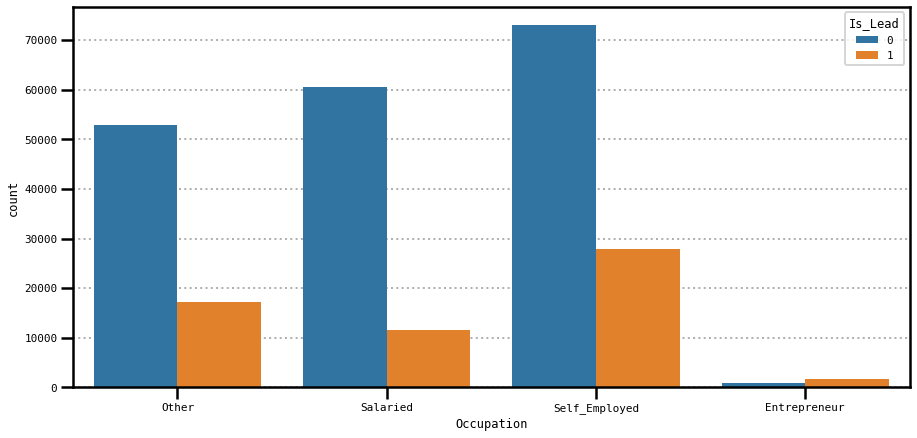

In [31]:
# Occupation

plt.subplots(figsize= (15, 7))
sns.countplot(x = 'Occupation', hue='Is_Lead', data=train_df);

In [32]:
# Other 
train_df[train_df['Occupation'] == 'Other']['Is_Lead'].value_counts(normalize=True) * 100

0    75.504824
1    24.495176
Name: Is_Lead, dtype: float64

In [33]:
# Salaried
train_df[train_df['Occupation'] == 'Salaried']['Is_Lead'].value_counts(normalize=True) * 100

0    84.033112
1    15.966888
Name: Is_Lead, dtype: float64

In [34]:
# Self_Employed
train_df[train_df['Occupation'] == 'Self_Employed']['Is_Lead'].value_counts(normalize=True) * 100

0    72.403505
1    27.596495
Name: Is_Lead, dtype: float64

In [35]:
# Entrepreneur
train_df[train_df['Occupation'] == 'Entrepreneur']['Is_Lead'].value_counts(normalize=True) * 100

1    66.066742
0    33.933258
Name: Is_Lead, dtype: float64

 Occupation 중

 - 'Other'의 제안 관심 비율 24.49%

 - 'Salaried'의 제안 관심 비율 15.96%

 - 'Self_Employed'의 제안 관심 비율 27.59%

 - 'Entrepreneur'의 제안 관심 비율 66.06%


 Entrepreneur의 66%가 제안에 관심이 많다. 하지만 절대 수가 적기 때문에 전체 비율에서 미치는 영향은 낮다.
 그 다음으로는 Self_Employed와 Other가 비슷한 비율을 보였고, Salaried의 관심 비율은 낮았다.

 사업가의 관심이 높은 제안이다.

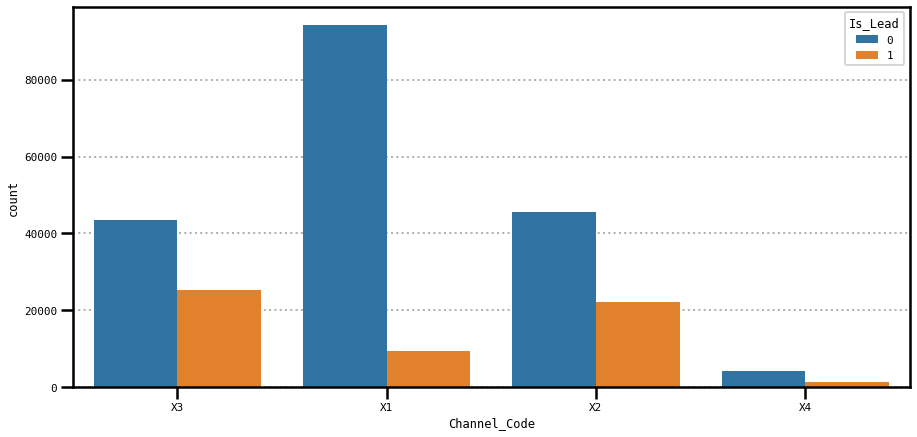

In [36]:
# Channel_Code

plt.subplots(figsize= (15, 7))
sns.countplot(x = 'Channel_Code', hue='Is_Lead', data=train_df);

In [37]:
train_df[train_df['Channel_Code'] == 'X1']['Is_Lead'].value_counts(normalize=True) * 100

0    90.857903
1     9.142097
Name: Is_Lead, dtype: float64

In [38]:
train_df[train_df['Channel_Code'] == 'X2']['Is_Lead'].value_counts(normalize=True) * 100

0    67.210525
1    32.789475
Name: Is_Lead, dtype: float64

In [39]:
train_df[train_df['Channel_Code'] == 'X3']['Is_Lead'].value_counts(normalize=True) * 100

0    63.297532
1    36.702468
Name: Is_Lead, dtype: float64

In [40]:
train_df[train_df['Channel_Code'] == 'X4']['Is_Lead'].value_counts(normalize=True) * 100

0    75.219968
1    24.780032
Name: Is_Lead, dtype: float64

 - X2, X3의 제안 관심 비율은 각각 32.78%, 36,70%로 나왔다.
 - X1의 관심 비율이 상대적으로 낮다.

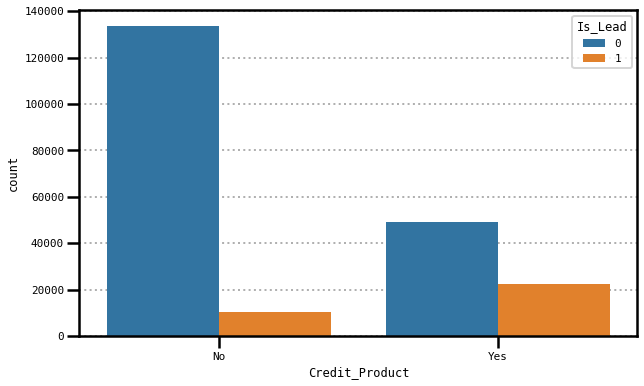

In [41]:
# Credit_Product
sns.countplot('Credit_Product', data=train_df, hue = 'Is_Lead');

In [42]:
train_df[train_df['Credit_Product'] == 'Yes']['Is_Lead'].value_counts(normalize=True) * 100

0    68.504921
1    31.495079
Name: Is_Lead, dtype: float64

In [43]:
train_df[train_df['Credit_Product'] == 'No']['Is_Lead'].value_counts(normalize=True) * 100

0    92.64116
1     7.35884
Name: Is_Lead, dtype: float64

* 이용 중인 'Credit_Product'가 있는 고객의 제안 관심 비율은 31.49%
* 이용 중인 'Credit_Product'가 없는 고객의 제안 관심 비율은 7.35%

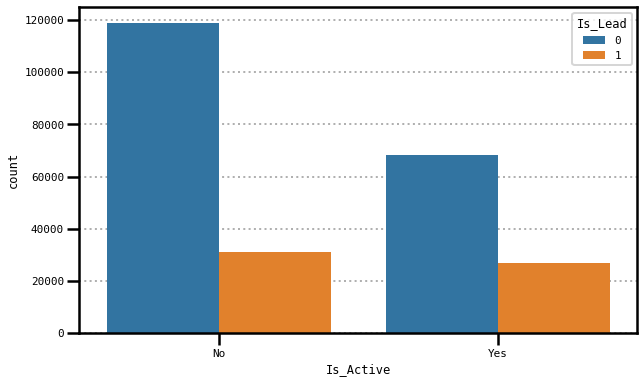

In [44]:
# Is_Active
sns.countplot('Is_Active', data=train_df, hue = 'Is_Lead');

In [45]:
train_df[train_df['Is_Active'] == 'Yes']['Is_Lead'].value_counts(normalize=True) * 100

0    71.703254
1    28.296746
Name: Is_Lead, dtype: float64

In [46]:
train_df[train_df['Is_Active'] == 'No']['Is_Lead'].value_counts(normalize=True) * 100

0    79.184909
1    20.815091
Name: Is_Lead, dtype: float64

* 'Is_Active'가 Yes인 고객 중 제안 관심 비율은 28.29%
* 'Is_Active'가 No인 고객 중 제안 관심 비율은 20.81%

## 이상치(Outlier) 제거

Numerical features의 이상치 제거

분석과 모델학습에 영향을 줄 수 있는 이상치를 제거한다.

In [47]:
Q1 = train_df[['Age','Vintage','Avg_Account_Balance']].quantile(q=0.25)
Q3 = train_df[['Age','Vintage','Avg_Account_Balance']].quantile(q=0.75)

print(Q1)
print(Q3)

Age                        30.0
Vintage                    20.0
Avg_Account_Balance    604310.0
Name: 0.25, dtype: float64
Age                         54.0
Vintage                     73.0
Avg_Account_Balance    1366666.0
Name: 0.75, dtype: float64


In [48]:
IQR = Q3 - Q1

IQR_df = train_df[(train_df['Age'] < (Q1['Age']-1.5*IQR['Age'])) | (train_df['Age'] > (Q3['Age']+1.5*IQR['Age']))]
IQR_df = train_df[(train_df['Vintage'] < (Q1['Vintage']-1.5*IQR['Vintage'])) | (train_df['Vintage'] > (Q3['Vintage']+1.5*IQR['Vintage']))]
IQR_df = train_df[(train_df['Avg_Account_Balance'] < (Q1['Avg_Account_Balance']-1.5*IQR['Avg_Account_Balance'])) | (train_df['Avg_Account_Balance'] > (Q3['Avg_Account_Balance']+1.5*IQR['Avg_Account_Balance']))]

print(IQR_df)


        Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
35      Female   29       RG284       Salaried           X1       26   
71        Male   27       RG254       Salaried           X1       13   
113     Female   27       RG268       Salaried           X1       21   
184     Female   74       RG268          Other           X3       33   
205       Male   33       RG268          Other           X1       25   
...        ...  ...         ...            ...          ...      ...   
245638    Male   48       RG283  Self_Employed           X2       31   
245653    Male   46       RG257  Self_Employed           X1       26   
245661  Female   30       RG276       Salaried           X1       15   
245676    Male   35       RG253  Self_Employed           X2       61   
245701    Male   32       RG277       Salaried           X1       13   

       Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
35                 No              2521592        No        0  
71     

In [49]:
train_df = train_df.drop(IQR_df.index, axis = 0)

print(train_df)

        Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0       Female   73       RG268          Other           X3       43   
1       Female   30       RG277       Salaried           X1       32   
2       Female   56       RG268  Self_Employed           X3       26   
3         Male   34       RG270       Salaried           X1       19   
4       Female   30       RG282       Salaried           X1       33   
...        ...  ...         ...            ...          ...      ...   
245720    Male   51       RG284  Self_Employed           X3      109   
245721    Male   27       RG268       Salaried           X1       15   
245722  Female   26       RG281       Salaried           X1       13   
245723  Female   28       RG273       Salaried           X1       31   
245724    Male   29       RG269       Salaried           X1       21   

       Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0                  No              1045696        No        0  
1      

### 범주형 데이터인 Credit_Product의 결측치 처리

In [50]:
# https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/ 
# 결측값을 가장 빈번한 값으로 대체하여 진행
train_df['Credit_Product'].value_counts()

No     136445
Yes     67344
Name: Credit_Product, dtype: int64

In [51]:
train_df = train_df.fillna(train_df.mode().iloc[0])
train_df['Credit_Product'].value_counts()

No     163769
Yes     67344
Name: Credit_Product, dtype: int64

cardinality가 높은 Region_Code feature를 삭제하고 진행하거나 LGBM 모델 사용

# 가설 검정 진행

### train_df를 train, validation 데이터로 나누기기

In [14]:
# stratify => 계층적 데이터 추출 옵션 (분류 모델에서 추천!) 여러 층으로 분할후 각 층별로 렌덤 데이터 추출, 원래 데이터의 분포와 유사하게 데이터 추출
train, val = train_test_split(train_df, train_size=0.80, test_size=0.20,
                              stratify = train_df['Is_Lead'], random_state=42)

In [15]:
train.shape, val.shape

((196580, 10), (49145, 10))

In [16]:
# 데이터에서 타겟과 특성 분리
features = train.drop(columns=[target]).columns

# train/val/test 데이터를 특성과 타겟으로 분리

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test_df[features]

In [17]:
# 분류문제의 기준모델 
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만들어 기준모델로 예측
pred = [major] * len(y_train)
val_pred = [major] * len(y_val)

print("training_accuracy_score: ", accuracy_score(y_train, pred))
print("validation_accuracy_score: ", accuracy_score(y_val, val_pred))

training_accuracy_score:  0.7627937735273171
validation_accuracy_score:  0.7627835995523451


# ML Model Test

## 파이프라인

In [19]:
lr = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)

lr.fit(X_train, y_train)

print('훈련세트 정확도', lr.score(X_train, y_train))
print('검증세트 정확도', lr.score(X_val, y_val))

y_pred = lr.predict(X_test)

훈련세트 정확도 0.7764319869773121
검증세트 정확도 0.7760504629158612


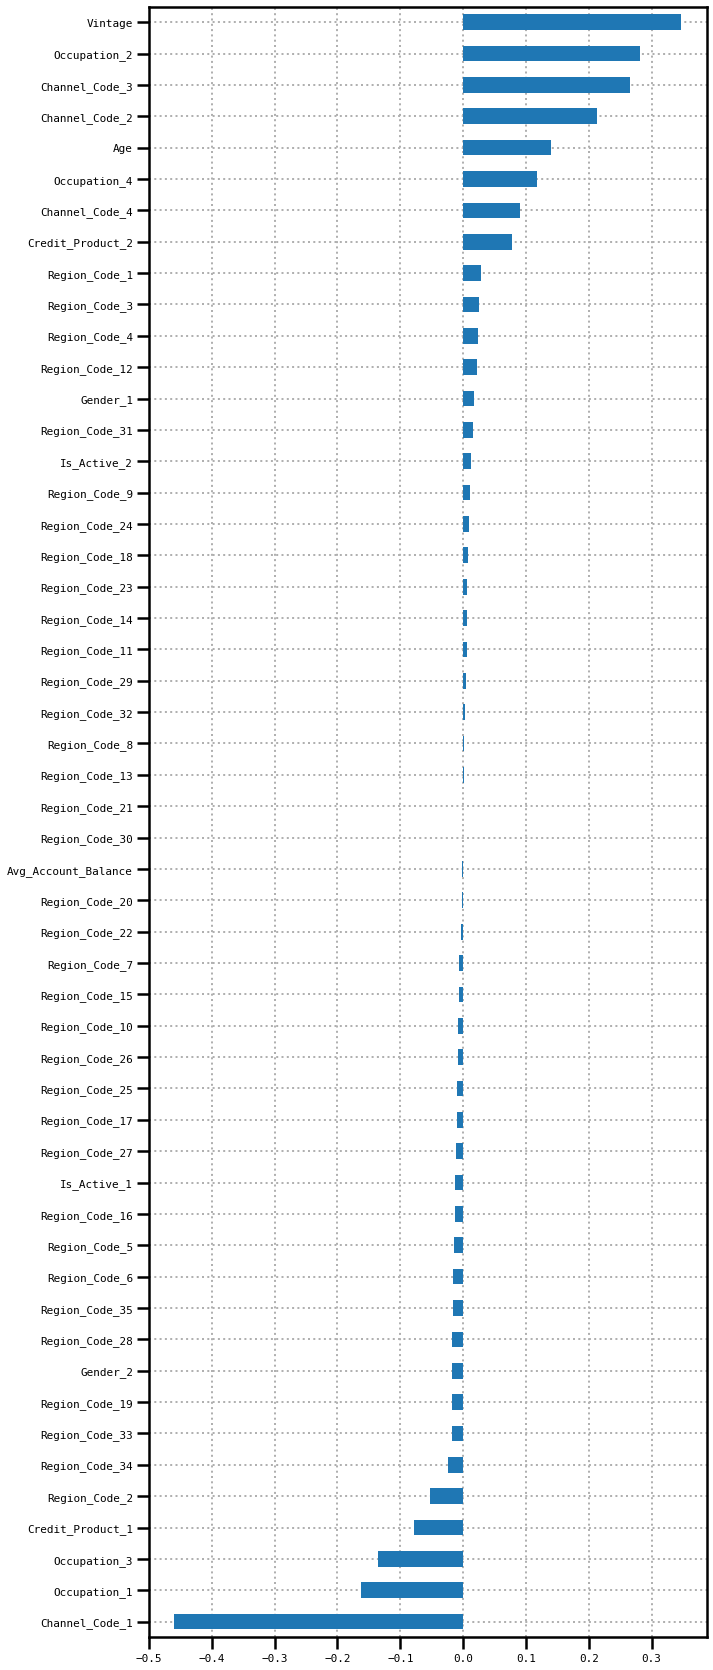

In [26]:
model_lr = lr.named_steps['logisticregression']
enc = lr.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns
coefficients = pd.Series(model_lr.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh();

In [14]:
# 과적합 발생
# dtc = make_pipeline(
#     OneHotEncoder(use_cat_names=True),
#     StandardScaler(),
#     DecisionTreeClassifier(random_state=42, criterion='entropy')
# )
                                                                                                                                                                                
# dtc.fit(X_train, y_train)
# print('훈련 정확도: ', dtc.score(X_train, y_train))
# print('검증 정확도: ', dtc.score(X_val, y_val))

훈련 정확도:  0.999994913012514
검증 정확도:  0.7134194729880965


In [23]:
dtc = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
)

dtc.fit(X_train, y_train)
print('훈련 정확도: ', dtc.score(X_train, y_train))
print('검증 정확도: ', dtc.score(X_val, y_val))

훈련 정확도:  0.8384983212941296
검증 정확도:  0.7616441143554787


In [24]:
dtc = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=6, random_state=42)
)

dtc.fit(X_train, y_train)
print('훈련 정확도: ', dtc.score(X_train, y_train))
print('검증 정확도: ', dtc.score(X_val, y_val))

훈련 정확도:  0.7868348763862041
검증 정확도:  0.784454166242751


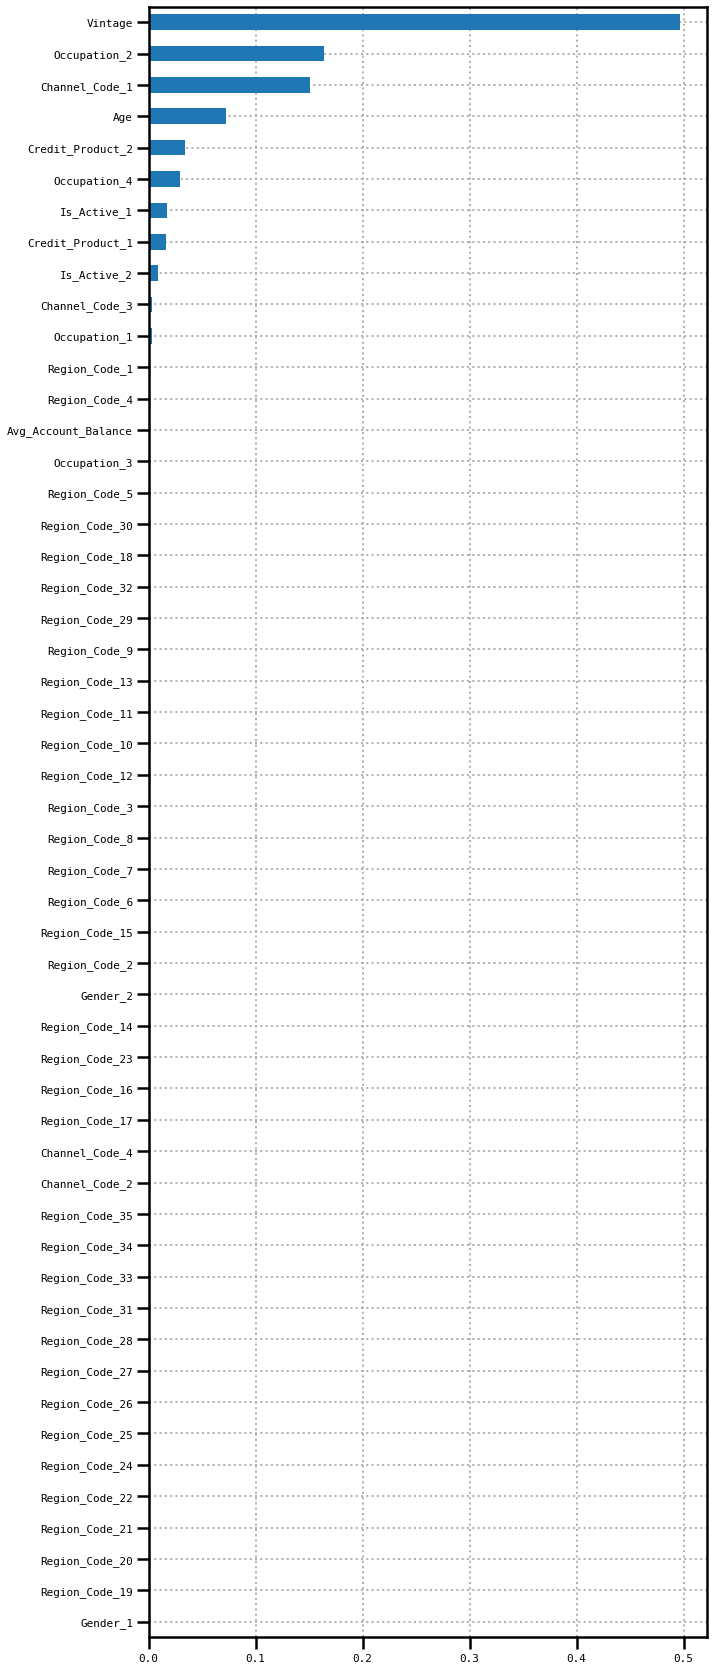

In [27]:
model_dtc = dtc.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dtc.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [30]:
rf = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True)
)

rf.fit(X_train, y_train)
print('검증 정확도: ', rf.score(X_val, y_val))

검증 정확도:  0.7750534133686031


### Categorical data 상관 관계 확인

Target feature 와의 상관관계

In [ ]:
plt.figure(figsize = (40,6))
sns.countplot(x = target_Vintage);

NameError: ignored

<Figure size 2880x432 with 0 Axes>

In [ ]:
non_target_Vintage = df[df['Is_Lead'] == 0]['Vintage']
non_target_Vintage

0         43
1         32
2         26
3         19
4         33
          ..
245719    13
245721    15
245722    13
245723    31
245724    21
Name: Vintage, Length: 183087, dtype: int64

In [ ]:
plt.figure(figsize = (40,6))
sns.countplot(x= non_target_Vintage);

In [ ]:
bins = np.linspace(df.Vintage.min(), df.Vintage.max(), 35)
plot1 = sns.FacetGrid(df, col = "Is_Lead", palette = 'Set1', col_wrap=2, size = 7)
plot1.map(plt.hist, 'Vintage', bins=bins, ec='k')

plot1.add_legend()
plt.show();

In [ ]:
# 두 그룹의 비율이 큰 차이가 나지 않기 때문에 그룹의 분산이 차이가 나지 않는다고 판단.
print(np.var(target_Vintage))

print(np.var(non_target_Vintage))

1193.689012866215
878.2364622836806


In [ ]:
stats.ttest_ind(target_Vintage, non_target_Vintage)

Ttest_indResult(statistic=106.79317277167486, pvalue=0.0)

H0 => µ1 = µ2

귀무가설 : 관심있는 고객들의 평균 Vintag는 관심없는 고객의 평균 Vintage와 차이가 없을 것이다.

HA => µ1 ≠µ2 

대안가설 : 관심있는 고객들의 평균 Vintage가 관심없는 고객의 평균 Vintage보다 유의미하게 높을 것이다.

신뢰도 95%

p-value가 0.05보다 낮기 때문에 귀무가설을 기각하고 대안가설을 채택한다.

-----
가설2

관심있는 고객들의 평균 'Avg_Account_Balance'가 관심없는 고객들의 평균  'Avg_Account_Balance'보다 유의미하게 낮을 것이다.

In [ ]:
target_AAB = df[df['Is_Lead'] == 1]['Avg_Account_Balance']
target_AAB

16        2282502
17        2384692
20        1001650
29        1056910
34        1684182
           ...   
245690     766548
245693    1122023
245697     551203
245709     608110
245713     898170
Name: Avg_Account_Balance, Length: 33313, dtype: int64

In [ ]:
non_target_AAB = df[df['Is_Lead'] == 0]['Avg_Account_Balance']
non_target_AAB

0         1045696
1          581988
2         1484315
3          470454
4          886787
           ...   
245719     354665
245721     862952
245722     670659
245723     407504
245724    1129276
Name: Avg_Account_Balance, Length: 183087, dtype: int64

In [ ]:
bins2 = np.linspace(df.Avg_Account_Balance.min(), df.Avg_Account_Balance.max(), 100)
plot2 = sns.FacetGrid(df, col = "Is_Lead", palette = 'Set1', col_wrap=2, size = 7)
plot2.map(plt.hist, 'Avg_Account_Balance', bins=bins2, ec='k')

plot2.add_legend()
plt.show();

In [ ]:
df['Avg_Account_Balance_log10'] = np.log10(df['Avg_Account_Balance'])

sns.histplot(df['Avg_Account_Balance_log10'], kde = True);
sns.histplot(df[df['Is_Lead'] == 1]['Avg_Account_Balance_log10'], kde = True, color="red");
sns.histplot(df[df['Is_Lead'] == 0]['Avg_Account_Balance_log10'], kde = True, color="green");

In [ ]:
print(np.var(target_AAB))

print(np.var(non_target_AAB))

753058638202.9728
715425557057.6074


In [ ]:
stats.ttest_ind(target_AAB, non_target_AAB)

Ttest_indResult(statistic=19.803560224508875, pvalue=3.3154586350694674e-87)

H0 => µ1 = µ2

귀무가설 : 관심있는 고객들의 평균 Avg_Account_Balance는 관심없는 고객의 평균 Avg_Account_Balance와 차이가 없을 것이다.

HA => µ1 ≠µ2 

대안가설 : 관심있는 고객들의 평균 Avg_Account_Balance가 관심없는 고객의 평균 Avg_Account_Balance보다 유의미하게 높을 것이다.

신뢰도 95%

p-value가 0.05보다 낮기 때문에 귀무가설을 기각하고 대안가설을 채택한다.

가설 3

특정 'Occupation'이 추천 신용카드에 관심있을 가능성이 유의미하게 높을 것이다.

In [ ]:
target_customers[target_customers['Occupation'] == 'Other']

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
34,FXPTJYP7,Male,67,RG268,Other,X1,87,Yes,1684182,No,1
53,JLHDNBUG,Male,60,RG268,Other,X3,104,Yes,1681503,No,1
212,COJX7JA2,Male,50,RG254,Other,X3,45,No,2019160,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245538,GXCOCBZG,Male,56,RG283,Other,X3,14,Yes,1251963,No,1
245594,FQNSJGQT,Female,54,RG268,Other,X1,87,No,1338017,No,1
245622,XCAGPM7X,Male,67,RG277,Other,X3,110,Yes,603838,No,1
245637,NNVMXGU7,Male,69,RG268,Other,X2,33,Yes,529781,No,1


In [ ]:
target_Occupation = df[df['Is_Lead'] == 1]['Occupation']
target_Occupation

16                Other
17                Other
20        Self_Employed
29        Self_Employed
34                Other
              ...      
245690    Self_Employed
245693            Other
245697         Salaried
245709    Self_Employed
245713    Self_Employed
Name: Occupation, Length: 33313, dtype: object

In [ ]:
non_tareget_Occupation = df[df['Is_Lead'] == 0]['Occupation']
non_tareget_Occupation

0                 Other
1              Salaried
2         Self_Employed
3              Salaried
4              Salaried
              ...      
245719         Salaried
245721         Salaried
245722         Salaried
245723         Salaried
245724         Salaried
Name: Occupation, Length: 183087, dtype: object

In [ ]:
plt.subplots(figsize= (15, 7))
sns.countplot(x = 'Occupation', hue='Is_Lead', data=df);

16            Other
17            Other
20    Self_Employed
29    Self_Employed
34            Other
Name: Occupation, dtype: object